In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import arviz as az
import jax
import numpyro

from hbmep.config import Config
from hbmep.model import Model
from hbmep.model.utils import Site as site

from hbmep_paper.model import HierarchicalBayesian, MaximumLikelihood, Simulator
from hbmep_paper.utils import simulate, run_experiment

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

In [23]:
src = "/home/vishu/repos/hbmep-paper/reports/comparison-2/run2/hierarchical_bayesian/mcmc.nc"

mcmc = az.from_netcdf(src)

a = mcmc["posterior"]["a"].to_numpy()
g_1 = mcmc["posterior"]["g_1"].to_numpy()
g_2 = mcmc["posterior"]["g_2"].to_numpy()
v = mcmc["posterior"]["v"].to_numpy()


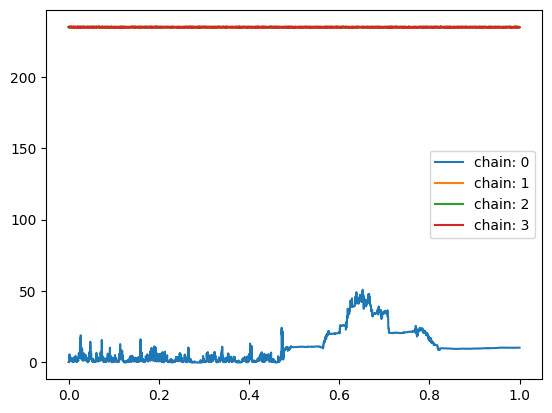

In [24]:
p, q, r = 0, 3, 0

import numpy as np
import seaborn as sns

x = np.linspace(0, 1, 6000)

for i in range(4):
    sns.lineplot(x=x, y=a[i, :, p, q, r], label=f"chain: {i}")

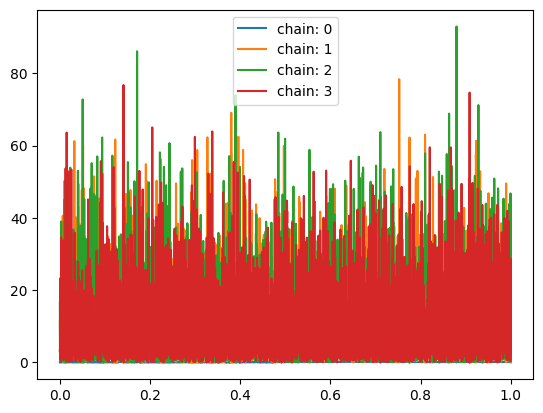

In [26]:
var = g_1

p, q, r = 0, 3, 0

import numpy as np
import seaborn as sns

x = np.linspace(0, 1, 6000)

for i in range(4):
    sns.lineplot(x=x, y=var[i, :, p, q, r], label=f"chain: {i}")

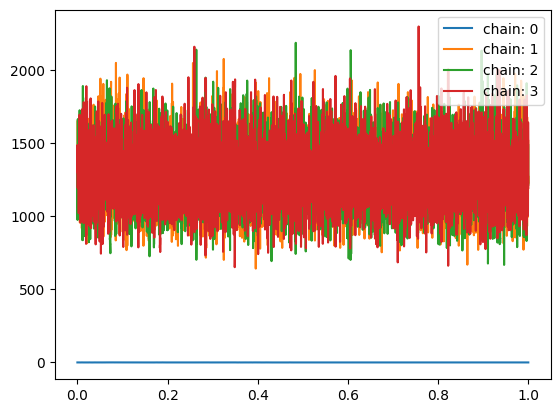

In [27]:
var = g_2

p, q, r = 0, 3, 0

import numpy as np
import seaborn as sns

x = np.linspace(0, 1, 6000)

for i in range(4):
    sns.lineplot(x=x, y=var[i, :, p, q, r], label=f"chain: {i}")

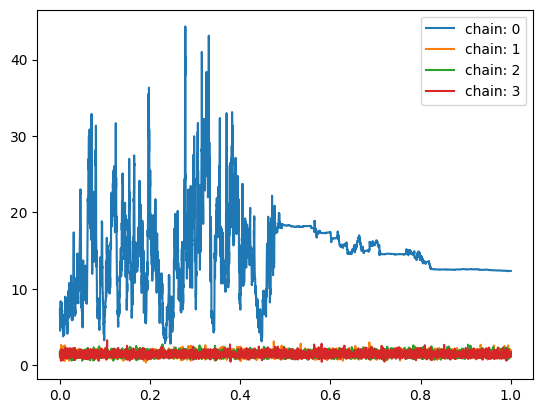

In [30]:
var = v

p, q, r = 0, 3, 0

import numpy as np
import seaborn as sns

x = np.linspace(0, 1, 6000)

for i in range(4):
    sns.lineplot(x=x, y=var[i, :, p, q, r], label=f"chain: {i}")

In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/experiments.toml")

config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/experiments-debug/"


2023-08-04 09:56:15,414 - hbmep.config - INFO - Verifying configuration ...
2023-08-04 09:56:15,415 - hbmep.config - INFO - Success!


In [3]:
simulator = Simulator(config=config)

simulation_params = {
    "n_subject": 5,
    "n_feature0": 15,
    "n_repeats": 100,
    "downsample_rate": 1
}
df, posterior_samples_true = simulate(model=simulator, **simulation_params)

2023-08-04 09:56:15,475 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-08-04 09:56:15,476 - hbmep_paper.utils.utils - INFO - Simulating data ...
2023-08-04 09:56:19,109 - hbmep.utils.utils - INFO - func:predict took: 3.63 sec
2023-08-04 09:56:19,118 - hbmep.utils.utils - INFO - func:simulate took: 3.64 sec


In [4]:
model = HierarchicalBayesian(config=config)

df, encoder_dict = model.load(df=df)

df[model.response] = posterior_samples_true[site.obs][3, ...]

2023-08-04 09:56:19,159 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-08-04 09:56:19,159 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/experiments-debug/
2023-08-04 09:56:19,160 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/experiments-debug/
2023-08-04 09:56:19,160 - hbmep.dataset.core - INFO - Processing data ...
2023-08-04 09:56:19,161 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
model.plot(df=df, encoder_dict=encoder_dict)

2023-08-04 09:56:19,225 - hbmep.dataset.core - INFO - Plotting dataset ...


2023-08-04 09:56:34,815 - hbmep.dataset.core - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/experiments-debug/dataset.pdf
2023-08-04 09:56:34,815 - hbmep.utils.utils - INFO - func:plot took: 15.59 sec


In [6]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-08-04 09:56:34,869 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
mcmc.print_summary(prob=.95)


                mean       std    median      2.5%     97.5%     n_eff     r_hat
  H[0,0,0]      1.47      0.74      1.24      0.71      2.85   4144.00      1.00
  H[0,1,0]      1.01      0.02      1.01      0.97      1.05  11107.16      1.00
  H[0,2,0]      3.65      0.04      3.65      3.56      3.74   5593.63      1.00
  H[1,0,0]      1.81      1.45      1.44      0.10      4.66   8326.44      1.00
  H[1,1,0]      0.14      0.00      0.14      0.14      0.15   8790.67      1.00
  H[1,2,0]      4.01      0.88      3.81      2.84      5.64   2331.80      1.00
  H[2,0,0]      0.98      0.08      0.97      0.85      1.14   4501.67      1.00
  H[2,1,0]      0.02      0.00      0.02      0.02      0.02   8715.27      1.00
  H[2,2,0]      0.39      0.02      0.39      0.34      0.44   5599.45      1.00
  H[3,0,0]      0.24      0.01      0.24      0.23      0.26   8885.68      1.00
  H[3,1,0]      0.49      0.00      0.49      0.48      0.50  12234.21      1.00
  H[3,2,0]      4.96      0

In [ ]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-03 15:34:16,172 - hbmep.model.baseline - INFO - Generating predictions ...


2023-08-03 15:34:53,929 - hbmep.utils.utils - INFO - func:predict took: 37.75 sec
2023-08-03 15:34:54,030 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-08-03 15:35:05,305 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/experiments-debug/recruitment_curves.pdf
2023-08-03 15:35:05,306 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 49.13 sec


In [ ]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-03 15:35:05,341 - hbmep.model.baseline - INFO - Generating predictions ...


2023-08-03 15:35:43,556 - hbmep.utils.utils - INFO - func:predict took: 38.21 sec
2023-08-03 15:35:44,541 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-08-03 15:36:02,653 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/experiments-debug/posterior_predictive_check.pdf
2023-08-03 15:36:02,659 - hbmep.utils.utils - INFO - func:render_predictive_check took: 57.32 sec
